## Outline

 - Create synthetic class imbalance
 - Load and preprocess data
 - Create `DataLoaders` for train and test sets
 - Define the model: one hidden layer
 - Train and evaluate model using grid search to select hidden layer size
 - Model selection
 - Visualisation

## Setup

In [981]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from collections import Counter

In [982]:
# reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

## Load and preprocess data

In [983]:
def make_imbalanced(X, y, target_counts):
    """
    X : np.array (n_samples, n_features)
    y : np.array (n_samples,)
    target_counts : dict {class_label: desired_count}
      - if desired_count > available -> oversample with replacement
      - if desired_count <= available -> subsample without replacement
    Returns: X_res, y_res (numpy arrays)
    """
    print("Simulating class distribution:", target_counts)
    np.random.seed(SEED)
    X_res_list, y_res_list = [], []
    classes = np.unique(y)

    for cls in classes:
        cls_idx = np.where(y == cls)[0]
        avail = len(cls_idx)

        desired = target_counts.get(int(cls), avail)  # default keep same if not specified

        if desired <= 0:
            continue
        if desired <= avail: # undersample without replacement
            chosen = np.random.choice(cls_idx, size=desired, replace=False)

        else: # oversample with replacement
            chosen = np.random.choice(cls_idx, size=desired, replace=True)

        X_res_list.append(X[chosen])
        y_res_list.append(y[chosen])

    X_res = np.vstack(X_res_list)
    y_res = np.concatenate(y_res_list)

    # shuffle resampled dataset
    perm = np.random.permutation(len(y_res))
    return X_res[perm], y_res[perm]

(150, 4) (150,)
Original class distribution: Counter({0: 50, 1: 50, 2: 50})


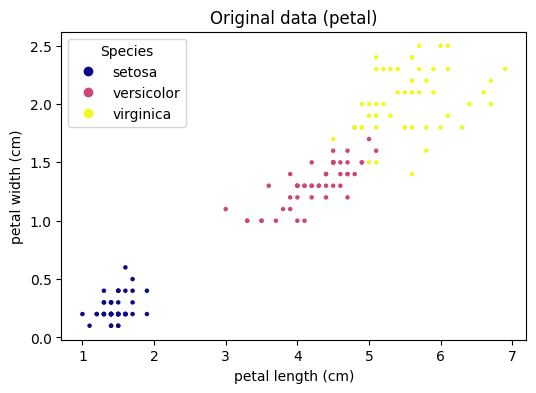

In [984]:
iris = load_iris()
X, y = iris.data, iris.target
print(X.shape, y.shape)

print("Original class distribution:", Counter(y))

plt.figure(figsize=(6,4))
scatter = plt.scatter(X[:, 2], X[:, 3], c=y, s=5, cmap='plasma')
plt.title("Original data (petal)")
plt.xlabel(iris.feature_names[2])
plt.ylabel(iris.feature_names[3])
handles, _ = scatter.legend_elements()
plt.legend(handles, iris.target_names, title="Species")
plt.show()

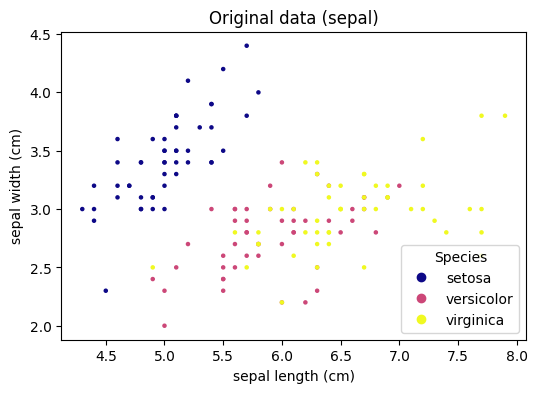

In [985]:
plt.figure(figsize=(6,4))
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, s=5, cmap='plasma')
plt.title("Original data (sepal)")
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
handles, _ = scatter.legend_elements()
plt.legend(handles, iris.target_names, title="Species")
plt.show()

In [986]:
# different imbalance ratios and differend classes as majority class
# setosa
# target_counts={0: 100, 1: 30, 2: 20}
# target_counts={0: 120, 1: 15, 2: 15}
# target_counts={0: 70, 1: 30, 2: 50}

# versicolor
# target_counts={0: 20, 1: 100, 2: 30}
# target_counts={0: 15, 1: 120, 2: 15}
# target_counts={0: 50, 1: 70, 2: 30}

# virginica
# target_counts={0: 20, 1: 30, 2: 100}
# target_counts={0: 15, 1: 15, 2: 120}
# target_counts = {0:30, 1:50, 2:70}

# original balanced dataset for comparison
X_imb = X.copy()
y_imb = y.copy()

# X_imb, y_imb = make_imbalanced(X, y, target_counts=target_counts)
print("Resampled class distribution:", Counter(y_imb))

Resampled class distribution: Counter({0: 50, 1: 50, 2: 50})


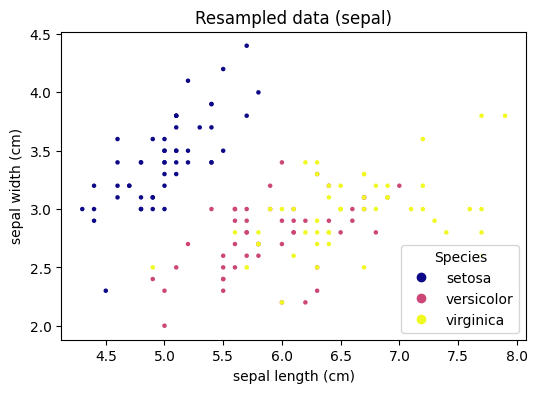

In [987]:
plt.figure(figsize=(6,4))
scatter = plt.scatter(X_imb[:, 0], X_imb[:, 1], c=y_imb, s=5, cmap='plasma')
plt.title("Resampled data (sepal)")
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
handles, _ = scatter.legend_elements()
plt.legend(handles, iris.target_names, title="Species")
plt.show()

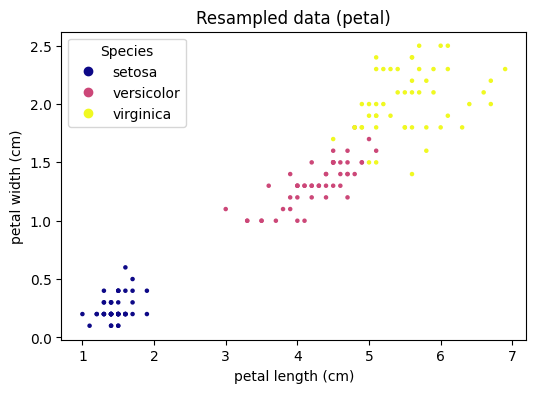

In [988]:
plt.figure(figsize=(6,4))
scatter = plt.scatter(X_imb[:, 2], X_imb[:, 3], c=y_imb, s=5, cmap='plasma')
plt.title("Resampled data (petal)")
plt.xlabel(iris.feature_names[2])
plt.ylabel(iris.feature_names[3])
handles, _ = scatter.legend_elements()
plt.legend(handles, iris.target_names, title="Species")
plt.show()

Normalise inputs ([Source](https://www.researchgate.net/publication/2811922_Efficient_BackProp))

In [989]:
scaler = StandardScaler()
X_imb = scaler.fit_transform(X_imb)

In [990]:
# train-test split
# stratify using class labels of imbalanced data set
X_train, X_valid, y_train, y_valid = train_test_split(X_imb, y_imb, train_size=0.6, random_state=SEED, stratify=y_imb)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, train_size=0.5, random_state=SEED, stratify=y_valid)

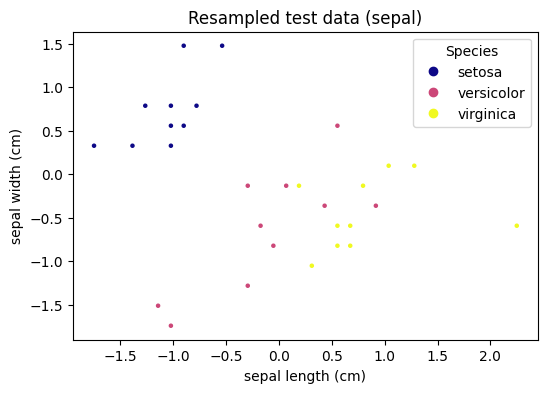

In [991]:
plt.figure(figsize=(6,4))
scatter = plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=5, cmap='plasma')
plt.title("Resampled test data (sepal)")
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
handles, _ = scatter.legend_elements()
plt.legend(handles, iris.target_names, title="Species")
plt.show()

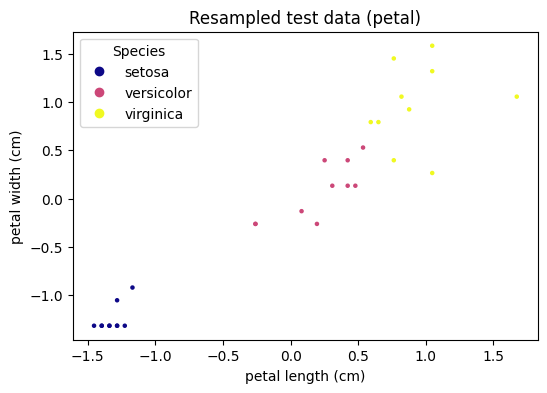

In [992]:
plt.figure(figsize=(6,4))
scatter = plt.scatter(X_test[:, 2], X_test[:, 3], c=y_test, s=5, cmap='plasma')
plt.title("Resampled test data (petal)")
plt.xlabel(iris.feature_names[2])
plt.ylabel(iris.feature_names[3])
handles, _ = scatter.legend_elements()
plt.legend(handles, iris.target_names, title="Species")
plt.show()

In [993]:
# create dataloaders
# first create tensors from np.arrays returned by train_test_split
# then create a torch Dataset
# then wrap an iterable around it to create a torch DataLoader

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
valid_ds = TensorDataset(X_valid_tensor, y_valid_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=16, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False)

# Vanilla model

## Define model

In [994]:
class IrisNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(IrisNN, self).__init__()
        
        if hidden_size == 0: # just a linear model
            self.net = nn.Linear(in_features= input_size, out_features= output_size)
        else:
            self.net = nn.Sequential(
                nn.Linear(input_size, hidden_size),
                nn.Tanh(),
                nn.Linear(hidden_size, output_size)
            )
            # don't include softmax here, CrossEntropyLoss does that internally
    
    def forward(self, x):
        return self.net(x)


## Training

In [995]:
def tune_iris(hidden, output_size, epochs, lr, 
              train_loader, test_loader, 
              classes_incl = iris.target_names, 
              holdout_loader = None, verbose=True):
    # specify architecture
    model = IrisNN(input_size=4, hidden_size=hidden, output_size=output_size)
    loss_func = nn.CrossEntropyLoss()
    optimiser = optim.Adam(model.parameters(), lr=lr)

    # record performance for later plotting
    train_perf = []
    test_perf = []
    num_epochs_used = epochs
    test_acc = -float("inf")

    # train and evaluate for each epoch
    for epoch in range(epochs):
        # training
        model.train()
        for (xb, yb) in train_loader:
            optimiser.zero_grad() # reset gradients from previous batch
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            optimiser.step()

        # evaluation   
        model.eval()
        with torch.no_grad():
            # training performance
            tr_preds, tr_targets = [], []
            for xb, yb in train_loader:
                logits = model(xb)
                preds = torch.argmax(logits, dim=1)
                tr_targets.append(yb.numpy())
                tr_preds.append(preds.numpy()) 
            
            tr_preds = np.concatenate(tr_preds)
                        
            tr_targets = np.concatenate(tr_targets)
            train_acc = balanced_accuracy_score(tr_targets, tr_preds)

            # test performance
            te_preds, te_targets = [], []
            for xb, yb in test_loader:
                logits = model(xb)
                preds = torch.argmax(logits, dim=1)
                te_targets.append(yb.numpy())
                te_preds.append(preds.numpy()) 
                
            te_preds = np.concatenate(te_preds)
            te_targets = np.concatenate(te_targets)
            test_acc = balanced_accuracy_score(te_targets, te_preds)

            if test_acc > 0.95:                
                train_perf.append(train_acc)
                test_perf.append(test_acc)
                num_epochs_used = epoch + 1 

                print(f"Satisfactory performance reached at epoch {num_epochs_used}, te_bal_acc={test_perf[-1]:.3f}")

                break

            if verbose and ((epoch + 1) % 10 == 0 or epoch == 0):
                print(f"h={hidden} Epoch {epoch+1}/{epochs} | tr_bal_acc={train_acc:.3f} te_bal_acc={test_acc:.3f}")
    
        train_perf.append(train_acc)
        test_perf.append(test_acc)

    # classification report printed at end of training
    report = classification_report(
        te_targets, 
        te_preds, 
        target_names=classes_incl,
        zero_division=0,
        digits=3 
    )

    print("VALIDATION SET PERFORMANCE")
    print(report)

    # add classification report on holdout set, but don't print
    # use for evaluating ICL performance
    holdout_report = None
    if holdout_loader is not None:
        ho_preds, ho_targets = [], []
        for xb, yb in holdout_loader:
            logits = model(xb)
            preds = torch.argmax(logits, dim=1)
            ho_targets.append(yb.numpy())
            ho_preds.append(preds.numpy()) 
                
        ho_preds = np.concatenate(ho_preds)
        ho_targets = np.concatenate(ho_targets)
        holdout_acc = balanced_accuracy_score(ho_targets, ho_preds)

        holdout_report = classification_report(
            ho_targets, 
            ho_preds, 
            target_names=iris.target_names,
            zero_division=0,
            digits=3 
        )

        if verbose:
            print(f"TEST SET PERFORMANCE")
            print(f"Holdout set performance (balanced accuracy): {holdout_acc:.3f}")
            print(holdout_report)
    
    return train_perf, test_perf, num_epochs_used, holdout_report

In [996]:
hidden_sizes = [0, 1, 2, 4, 8, 16, 32]
epochs = 30
results = {}

SEED = 43
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

for h in hidden_sizes:
    print(f"\n=== Full model with hidden_size = {h} ===")
    train_hist, test_hist, num_epochs, holdout_hist = tune_iris(hidden=h, output_size=3, epochs=epochs, lr=0.001,
                                                  train_loader=train_loader, test_loader=valid_loader,
                                                  verbose=True)
    results[h] = {"train": train_hist, "test": test_hist, "num_epochs_used": num_epochs, "holdout": holdout_hist}


=== Full model with hidden_size = 0 ===
h=0 Epoch 1/30 | tr_bal_acc=0.378 te_bal_acc=0.267
h=0 Epoch 10/30 | tr_bal_acc=0.444 te_bal_acc=0.400
h=0 Epoch 20/30 | tr_bal_acc=0.622 te_bal_acc=0.500
h=0 Epoch 30/30 | tr_bal_acc=0.756 te_bal_acc=0.700
VALIDATION SET PERFORMANCE
              precision    recall  f1-score   support

      setosa      1.000     0.800     0.889        10
  versicolor      0.571     0.400     0.471        10
   virginica      0.600     0.900     0.720        10

    accuracy                          0.700        30
   macro avg      0.724     0.700     0.693        30
weighted avg      0.724     0.700     0.693        30


=== Full model with hidden_size = 1 ===
h=1 Epoch 1/30 | tr_bal_acc=0.333 te_bal_acc=0.333
h=1 Epoch 10/30 | tr_bal_acc=0.333 te_bal_acc=0.333
h=1 Epoch 20/30 | tr_bal_acc=0.333 te_bal_acc=0.333
h=1 Epoch 30/30 | tr_bal_acc=0.489 te_bal_acc=0.467
VALIDATION SET PERFORMANCE
              precision    recall  f1-score   support

      setosa  

### Visualisation

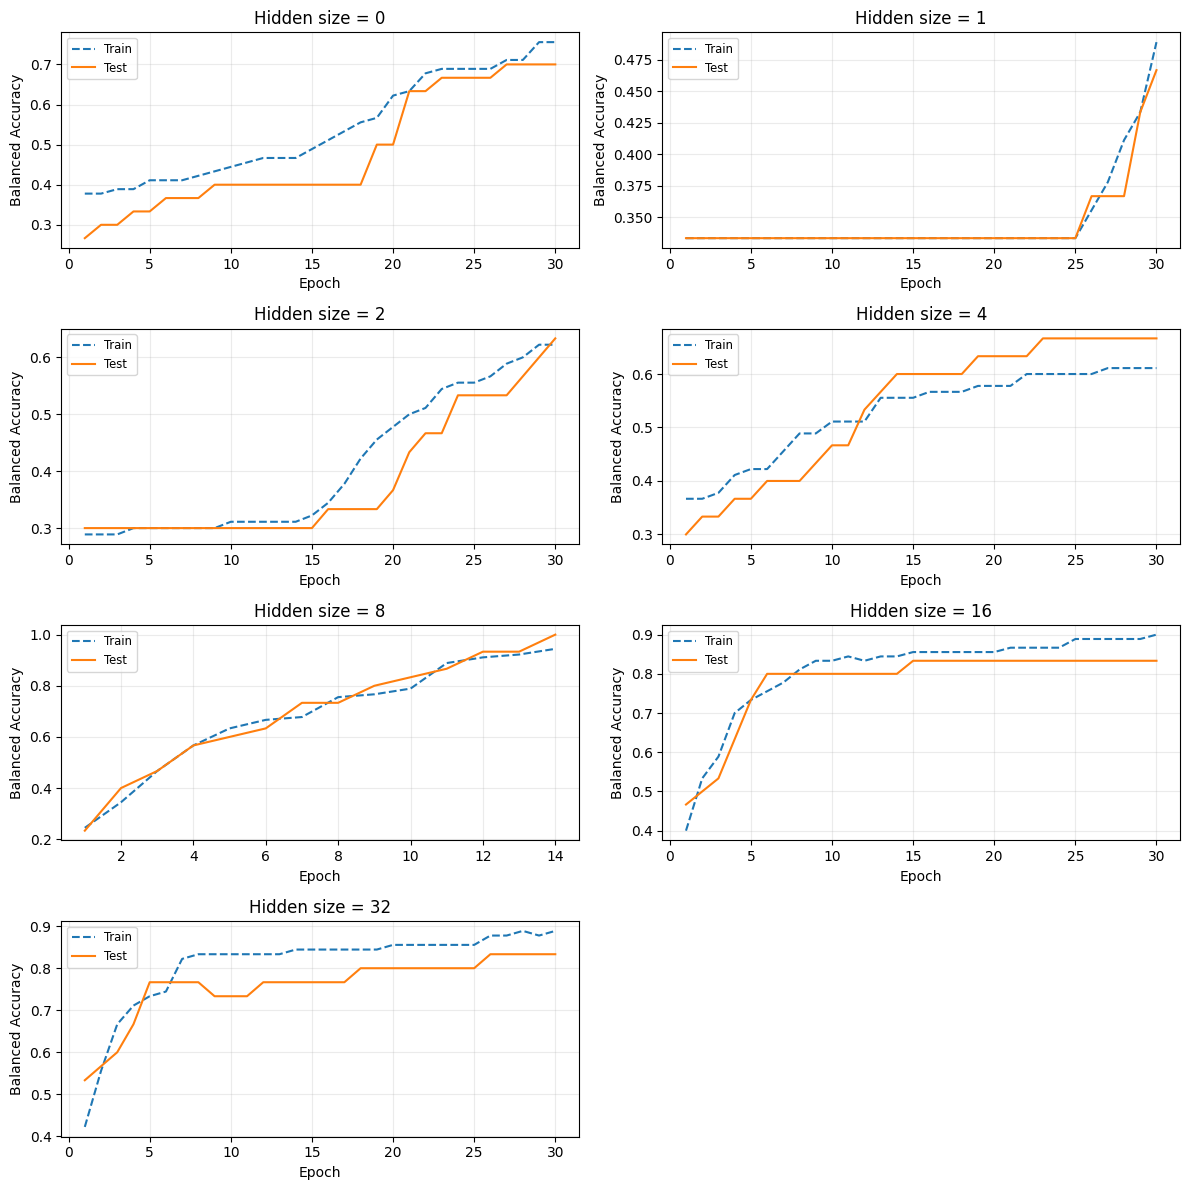

In [997]:
n_rows, n_cols = 4, 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 12))
axes = axes.flatten()

for i, h in enumerate(hidden_sizes):
    ax = axes[i]
    t = results[h]["train"]
    v = results[h]["test"]
    num_epochs = results[h]["num_epochs_used"]

    ax.plot(range(1, num_epochs+1), t, linestyle="--", label="Train")
    ax.plot(range(1, num_epochs+1), v, linestyle="-", label="Test")
    ax.set_title(f"Hidden size = {h}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Balanced Accuracy")
    ax.legend(fontsize="small")
    ax.grid(alpha=0.25)

# remove unused subplots (if hidden_sizes < 4*2)
for j in range(i+1, n_rows*n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Final model

In [998]:
best_h = max(results, key=lambda h: results[h]["test"][-1])
print(f"\nBest hidden size: {best_h} with final test accuracy {results[best_h]['test'][-1]:.4f}")

final_mod_res = tune_iris(
    hidden=best_h, 
    output_size=3, 
    epochs=30, 
    lr=0.001,
    train_loader=train_loader, 
    test_loader=valid_loader, 
    holdout_loader=test_loader,
    verbose=True
)


Best hidden size: 8 with final test accuracy 1.0000
h=8 Epoch 1/30 | tr_bal_acc=0.356 te_bal_acc=0.333
h=8 Epoch 10/30 | tr_bal_acc=0.511 te_bal_acc=0.533
h=8 Epoch 20/30 | tr_bal_acc=0.833 te_bal_acc=0.833
h=8 Epoch 30/30 | tr_bal_acc=0.844 te_bal_acc=0.833
VALIDATION SET PERFORMANCE
              precision    recall  f1-score   support

      setosa      1.000     1.000     1.000        10
  versicolor      0.857     0.600     0.706        10
   virginica      0.692     0.900     0.783        10

    accuracy                          0.833        30
   macro avg      0.850     0.833     0.829        30
weighted avg      0.850     0.833     0.829        30

TEST SET PERFORMANCE
Holdout set performance (balanced accuracy): 0.867
              precision    recall  f1-score   support

      setosa      1.000     1.000     1.000        10
  versicolor      0.750     0.900     0.818        10
   virginica      0.875     0.700     0.778        10

    accuracy                          0.86

# Incremental Class Learning

In [999]:
class_order = sorted(target_counts, key=target_counts.get)

In [1000]:
# implement incremental class learning
# 1. subset data
# 2. train model on subset
# 3. underfits? add hidden neurons and retrain
# 4. satisfactory performance? add next class and repeat from 1

def incr_class_learning(class_order, X_train, X_valid, y_train, y_valid, test_loader):
    results = []
    hidden = 0
    for step in range(2, len(class_order)+1):
        # 1. subset data
        current_classes = class_order[:step]

        # create mapping: original label -> new label (for CrossEntropyLoss)
        label_map = {orig: new for new, orig in enumerate(current_classes)}
        
        # subset train and test data to only current classes
        mask_train = np.isin(y_train, current_classes)
        X_train_sub, y_train_sub = X_train[mask_train], y_train[mask_train]
        mask_valid = np.isin(y_valid, current_classes)
        X_valid_sub, y_valid_sub = X_valid[mask_valid], y_valid[mask_valid]
        
        # remap labels
        y_train_remap = np.vectorize(label_map.get)(y_train_sub)
        y_valid_remap = np.vectorize(label_map.get)(y_valid_sub)
        
        # convert everything to tensors
        X_train_tensor = torch.tensor(X_train_sub, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train_remap, dtype=torch.long)
        X_valid_tensor = torch.tensor(X_valid_sub, dtype=torch.float32)
        y_valid_tensor = torch.tensor(y_valid_remap, dtype=torch.long)
        
        # create datasets and dataloaders
        train_ds = TensorDataset(X_train_tensor, y_train_tensor)
        valid_ds = TensorDataset(X_valid_tensor, y_valid_tensor)

        train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
        valid_loader = DataLoader(valid_ds, batch_size=16, shuffle=False)
        
        print(f"Training on classes: {class_order[:step]}")
        print(f"Initial hidden size: {hidden}, output size: {step}")

        results.append({
            "classes": class_order[:step],
            "hidden_tried": [],
            "train_hist": [],
            "test_hist": []
        })

        while True:
            # 2. train model on subset
            train_hist, test_hist, _, _ = tune_iris(hidden=hidden, output_size=step, epochs=30, lr=0.001, 
                                              train_loader=train_loader, test_loader=valid_loader,
                                              classes_incl= iris.target_names[class_order[:step]],
                                            verbose=True)
            results[-1]["hidden_tried"].append(hidden)
            results[-1]["train_hist"].append(train_hist)
            results[-1]["test_hist"].append(test_hist)

            test_acc = np.array(test_hist)[-3:].mean()

            # 3. if underfitting, increase hidden and retrain
            # 4. if performance satisfactory, add next class
            if test_acc >= 0.8:
                print(f"Hidden size {hidden} achieved mean test balanced accuracy {test_acc}. Moving to next class.\n")
                break
            else:
                hidden += 1
                print(f"Underfitting detected (mean test balanced accuracy {test_acc}), increasing hidden size to {hidden}.\n")


    return results

In [1001]:
np.random.seed(42)
torch.manual_seed(42)
results = incr_class_learning(class_order, X_train, X_test, y_train, y_test, test_loader)

Training on classes: [0, 1]
Initial hidden size: 0, output size: 2
h=0 Epoch 1/30 | tr_bal_acc=0.317 te_bal_acc=0.500
h=0 Epoch 10/30 | tr_bal_acc=0.467 te_bal_acc=0.550
h=0 Epoch 20/30 | tr_bal_acc=0.550 te_bal_acc=0.650
h=0 Epoch 30/30 | tr_bal_acc=0.617 te_bal_acc=0.650
VALIDATION SET PERFORMANCE
              precision    recall  f1-score   support

      setosa      0.588     1.000     0.741        10
  versicolor      1.000     0.300     0.462        10

    accuracy                          0.650        20
   macro avg      0.794     0.650     0.601        20
weighted avg      0.794     0.650     0.601        20

Underfitting detected (mean test balanced accuracy 0.65), increasing hidden size to 1.

h=1 Epoch 1/30 | tr_bal_acc=0.500 te_bal_acc=0.500
h=1 Epoch 10/30 | tr_bal_acc=0.500 te_bal_acc=0.500
h=1 Epoch 20/30 | tr_bal_acc=0.500 te_bal_acc=0.500
h=1 Epoch 30/30 | tr_bal_acc=0.500 te_bal_acc=0.500
VALIDATION SET PERFORMANCE
              precision    recall  f1-score   supp

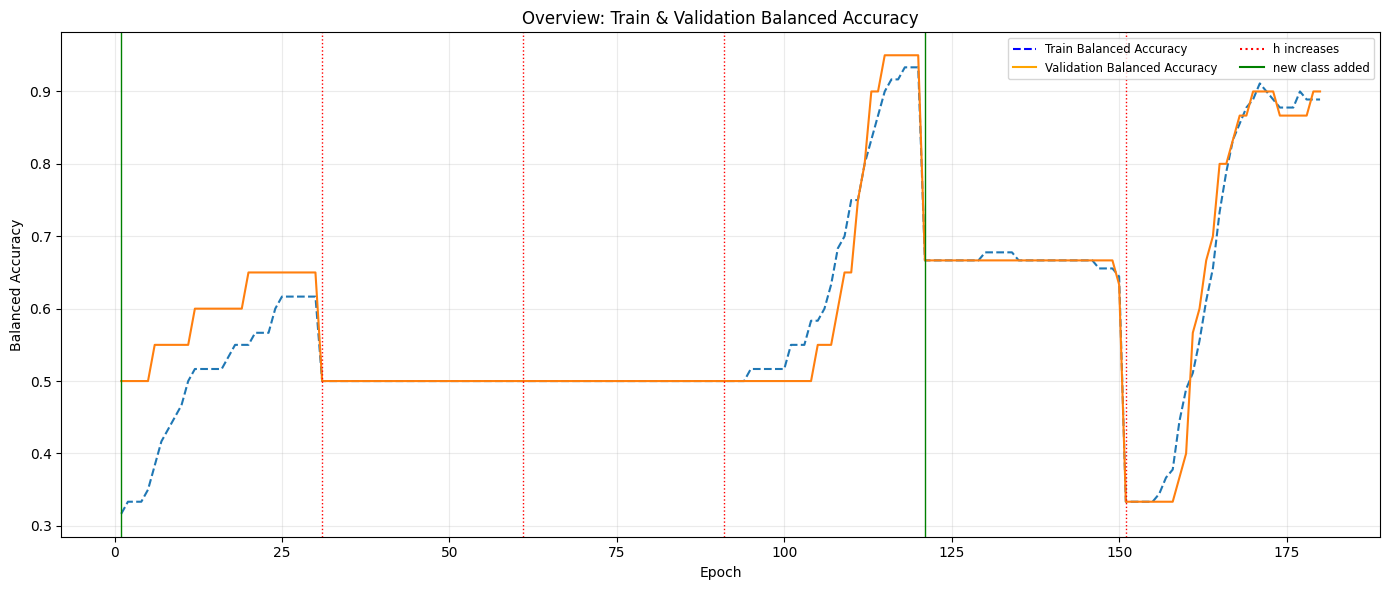

<Figure size 640x480 with 0 Axes>

In [1002]:
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

train_acc = []
test_acc = []
h_change_epochs = []
class_change_epochs = []
cumulative_epoch = 0

for step_idx, config_results in enumerate(results):
    # mark where this class-configuration starts (new class added)
    class_change_epochs.append(cumulative_epoch + 1)  # 1-based epoch index

    for j, h in enumerate(config_results["hidden_tried"]):
        t = config_results["train_hist"][j]
        v = config_results["test_hist"][j]

        # if this is not the first trial for this class config, a hidden-size increase happened
        if j > 0:
            h_change_epochs.append(cumulative_epoch + 1)

        train_acc.extend(t)
        test_acc.extend(v)
        cumulative_epoch += len(t)

epochs_total = range(1, len(train_acc) + 1)
plt.figure(figsize=(14, 6))
plt.plot(epochs_total, train_acc, linestyle="--", label="Train Balanced Accuracy")
plt.plot(epochs_total, test_acc, linestyle="-", label="Validation Balanced Accuracy")

# vertical lines: hidden increases (red) and new class added (green)
for xc in h_change_epochs:
    plt.axvline(x=xc, color="red", linestyle=":", linewidth=1)

for xc in class_change_epochs:
    plt.axvline(x=xc, color="green", linestyle="-", linewidth=1)

# build a clean legend (avoid duplicate axis labels)
train_line = mlines.Line2D([], [], linestyle="--", label="Train Balanced Accuracy", color="blue")
test_line = mlines.Line2D([], [], linestyle="-", label="Validation Balanced Accuracy", color ="orange")
h_line = mlines.Line2D([], [], color="red", linestyle=":", label="h increases")
c_line = mlines.Line2D([], [], color="green", linestyle="-", label="new class added")
plt.legend(handles=[train_line, test_line, h_line, c_line], ncol=2, fontsize="small")

plt.xlabel("Epoch")
plt.ylabel("Balanced Accuracy")
plt.title("Overview: Train & Validation Balanced Accuracy")
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()
plt.savefig("iris_inc.png")

In [1003]:
!jupyter nbconvert --to html iris_nn.ipynb --output iris_nn_10.html --output-dir ./output/

[NbConvertApp] Converting notebook iris_nn.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 8 image(s).
[NbConvertApp] Writing 898471 bytes to output/iris_nn_10.html
